In [1]:
# MOSFET Drain current prediction
#Import required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



**Load dataset containing Id, Vgs and Vds value of a long channel MOSFET L=1um**

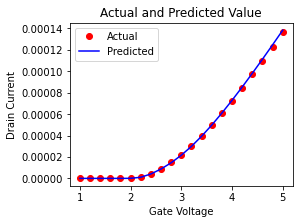

In [2]:
df = pd.read_csv('../input/mosfet-characteristics/training_data.csv')

**Remove Zero values before data normalization , otherwise logarithm can't work**

In [3]:
df["Id"].replace({0:1e-13}, inplace=True)
df["Vgs"].replace({0:1e-3}, inplace=True)
df["Vds"].replace({0:1e-3}, inplace=True)
id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
yy=np.ravel(id)
X1=df.iloc[:,0:2]
X=np.log10(X1)

**Split dataset into train and test set**

In [4]:
# Split train and test dataset
from sklearn.model_selection import train_test_split


**Normalize drain current value, since output activation function is sigmoid, so normalized Id value should be within 0 and 1**

In [5]:
#Normalize data before training
#Revised
#y=np.log10(yy)
y=-1/np.log10(yy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train=y_train.reshape(-1,1) #reshape the data before feeding to network
y_test=y_test.reshape(-1,1)

**Import Tensorflow and Keras**

In [6]:
import tensorflow as tf
from tensorflow import keras

**Build the model. 1st three layer contains 16,8,4 Neuron with tanh activation. Hyp-tah activation finction ensure the continuous derivative of result at a cost of more epoch**

Note: Relu as activation finction may be used for hidden layers but result might not be smooth. For any compact model, it should be continuous so that it is compatible with Newton algorithm which is used in SPICE simulators.

**Note that the Training will take a long time. You can reduce no of epoch but it may affect model accuracy**

In [7]:
# We'll use Keras to create a Neural network
model = tf.keras.Sequential()
model.add(keras.layers.Dense(16, activation='tanh', input_shape=(2,)))
model.add(keras.layers.Dense(8,activation='tanh'))
model.add(keras.layers.Dense(4,activation='tanh'))
#model.add(keras.layers.Dense(4,activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_1 = model.fit(X_train, y_train, epochs=1000, 
                        validation_data=(X_test, y_test))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/1000
713/713 [==============================] - 2s 2ms/step - loss: 0.0113 - mae: 0.0529 - val_loss: 3.3865e-04 - val_mae: 0.0151
Epoch 2/1000
713/713 [==============================] - 1s 2ms/step - loss: 3.0792e-04 - mae: 0.0146 - val_loss: 2.5697e-04 - val_mae: 0.0135
Epoch 3/1000
713/713 [==============================] - 2s 2ms/step - loss: 2.3171e-04 - mae: 0.0127 - val_loss: 1.9868e-04 - val_mae: 0.0118
Epoch 4/1000
713/713 [==============================] - 1s 2ms/step - loss: 1.8096e-04 - mae: 0.0111 - val_loss: 1.4447e-04 - val_mae: 0.0100
Epoch 5/1000
713/713 [==============================] - 1s 2ms/step - loss: 1.2412e-04 - mae: 0.0091 - val_loss: 9.4528e-05 - val_mae: 0.0079
Epoch 6/1000
713/713 [==============================] - 1s 2ms/step - loss: 7.6801e-05 - mae: 0.0068 - val_loss: 5.7300e-05 - val_mae: 0.0058
Epoch 7/1000
713/713 [==============================] - 1s 2ms/step - loss: 4.6649e-05 - mae: 0.0052 - val_loss: 3.7002e-05 - val_mae: 0.0047
Epoch 8/10

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

**Plot loss**

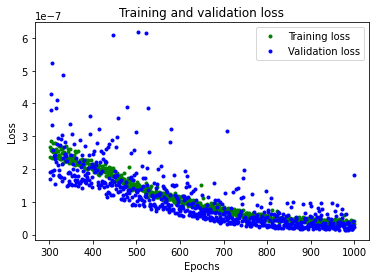

In [9]:
# Exclude the first few epochs so the graph is easier to read
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 300
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Apply a new data for prediction. Normalize data before feeding to network**

In [10]:
# New data input for testing
df1 = pd.read_csv('../input/mosfet-characteristics/val06.csv') #val05 test data needs to be processed
df1["id"].replace({0:1e-13}, inplace=True)
df1["vgs"].replace({0:1e-3}, inplace=True)
df1["vds"].replace({0:1e-3}, inplace=True)
val_feature=df1.iloc[:,0:2]
xnew=val_feature
ynew=np.ravel(df1["id"])
#Normalize validation data
xval=np.log10(xnew)
#xval=xnew/5
yval=-1/np.log10(ynew)
yval=yval.reshape(-1,1)

**Plot actual vs. predicted result. Make sure that predicted drain current is de-normalized before plotting.**

*De-normalization required because before feeding to network (training phase), we have converted drain current within 0 to 1 range  so that Sigmoid function can operate. So, predicted current value will be within same range. It should be converted back to it's original form (De-normalization)*

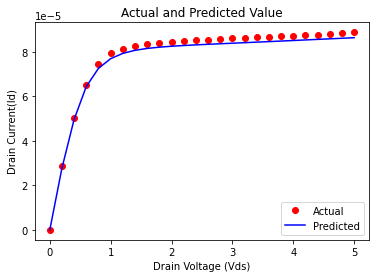

In [11]:
# Predict the new dataset
y_pred = model.predict(xval)
#plot the result
vg1=df1["vds"] #change this index to vgs if you are going to plot Id-Vg
vg=np.ravel(vg1)
vg=vg.reshape(-1,1)
#print(vg)
plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')
plt.plot(vg,10**(-1/y_pred), 'b', label='Predicted')
#plt.yscale("log")
plt.title('Actual and Predicted Value')
plt.xlabel('Drain Voltage (Vds)')
plt.ylabel('Drain Current(Id)')
plt.legend()

**Integration with SPICE simulators**

One important and desirable feature of model is, it should be SPICE compatible. So that it can be used to design circuit and can be simulated along with other components such as voltage sources, resistors, capacitors etc. But, the mode presented here is a standalone. To integrate it with circuit simulator such as **CADENCE**, this model needs to be exported into Verilog-A langulate which is supported by all commercial simulators. Once, the model training and testing is done in Python, the trained model is exported intp Verilog-A and successfully implemented and tested in **CADENCE SPECTRE**, and interesting thing is that it works smoothly without any issues. Execution time is same compared to other built-in models.

*The code presented here is a part of our model development framework. Hope, it will encourage others to develop MOSFET models based upon Neural network.*